## Similiarity Rating Interpolation Project

_Written by Ariel Zeleznikow-Johnston  
ariel.zeleznikow-johnston@monash.edu  
Last updated 11-Nov-2020_

This project is an attempt to simulate similarity rating interpolations from incomplete data. The aim of this part of the project is to see if a colour hue circle in phenomenological space can be ascertained from incomplete comparisons of samples within that space, given different similarity rating generation metrics

In [563]:
# libraries
library(MASS) # for MDS
library(ggplot2) # for plotting
library(RColorBrewer) # for colour scales in plots
library(gridExtra) # for merging plots
library(grid) # for merging plots
library(ggplotify) # for merging plots

Warning message:
"package 'ggplotify' was built under R version 3.6.3"

In [397]:
# Define some constants
n.dim = 2
radius = 1
#dr.max = 1
dr.min = 0
exp.const = 2
n.qualia=9

### The phenomenological space

First, we need to define the space from which we're going to try and obtain similarity ratings. For current purposes, we're going to define an isoluminant maximally-saturated hue circle as a unit circle in a metric space of R<sup>2</sup>

In [19]:
# Polar to cartesian 
pol2cart <- function(radius,angle){
    x <- radius*cos(angle)
    y <- radius*sin(angle)
    return(c(x,y))
}

In [44]:
# Get samples from the hue circle
sample.hue.circle <- function(n.samples, distribution='uniform',offset=0, format='cartesian'){
    output <- matrix(, nrow = n.samples, ncol = n.dim) # initialise the output matrix
    
    # obtain the samples
    interval.angle <- 2*pi/n.samples
    for(i in (1:n.samples)){
        theta <- i*interval.angle + offset*interval.angle
        if(format == 'cartesian'){
            output[i,1:2] <- pol2cart(radius,theta)
        } else if (format == 'polar'){
            output[i,1:2] <- c(radius,theta)
        }
    }
    return(output)
}

In [310]:
# colour the plot appropriately
colors <- function(Q1,Q2){
    
    n.Q1 <- nrow(Q1)
    n.Q2 <- nrow(Q2)
    
    #colors.Q1 <- brewer.pal(n.Q1,'Greens')
    colors.Q1 <- rep('#FFFFB3',n.Q1)
    #colors.Q2 <- brewer.pal(n.Q2,'PuRd')
    colors.Q2 <- rep('"#BEBADA',n.Q2)
    
    return(c(colors.Q1,colors.Q2))
}

In [311]:
# label the plot points appropriately
labels <- function(Q1,Q2){
    n.Q1 <- nrow(Q1)
    n.Q2 <- nrow(Q2)
    
    i.Q1 <- c(1:n.Q1)
    labels.Q1 <- paste('QA',i.Q1,sep='_')
    i.Q2 <- c(1:n.Q2)
    labels.Q2 <- paste('QB',i.Q2,sep='_')
    
    return(c(labels.Q1,labels.Q2))
}

In [312]:
# plot sampled hue circles
sample.plot <- function(Q1,Q2){
    
    colors <- colors(Q1,Q2)
    points <- rbind(Q1,Q2)
    colnames(points) <- c('V1','V2')
    points <- data.frame(points)
    points$labels <- labels(Q1,Q2)
    
    plot <-     ggplot(points, aes(x = V1, y = V2, color=colors)) + geom_point(size =10) + 
                geom_text(aes(label=labels, vjust=-2)) +
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle('Phenomenological Space') + theme(legend.position='none')
    return(plot)
}

Let's obtain some samples

In [398]:
Q1 <- sample.hue.circle(n.samples=n.qualia)
Q2 <- sample.hue.circle(n.samples=n.qualia, offset=0.5)

In [399]:
qspace.plot <- sample.plot(Q1,Q2)

### Generating similarity ratings

Next, we need to calculate the similarity ratings based on the samples obtained and some metric that can provide dissimilarities based on two points in the phenomenological space

In [535]:
# Different distance functions
d.euclidean <- function(a,b){
    d <- sqrt( (a[1]-b[1])**2 + (a[2]-b[2])**2 )
    return(d)
}

d.shepard <- function(a,b){
    d.eu <- d.euclidean(a,b)
    d.shepard <- exp.const**d.eu-1
    return(d.shepard)
}

In [536]:
# Add some noise to the similarity ratings
noise <-function(var,dr.max,type='gaussian'){
    if(type=='gaussian'){
        error <- rnorm(1,mean=0,sd=var) * dr.max
    }
    return(error)
}

In [537]:
# Obtain dissimilarity ratings given some metric and two qualia sets in phenomenological space
dr <- function(n.samples,Q1,Q2,metric='d.shepard',var=0){
    
    method <- match.fun(metric) # select the metric of choice
    mat <- matrix(,nrow=n.samples*2,ncol=n.samples*2)  # initialise a matrix
    dr.max <- method(c(-1,-1),c(1,1)) # Find the maximum possible dissimilarity rating
    
    # populate the Q1 x Q2 matrix
    for(i in (1:n.samples)){
        q1 <- Q1[i,1:2]
        for(j in (1:n.samples)){
            q2 <- Q2[j,1:2]
            mat[i,j+n.samples] <- (method(q1,q2) + noise(var,dr.max=dr.max))/dr.max # not sure this is calculated correctly
        }
    }
    # transpose the results to make the bottom right comparisons
    mat[(n.samples+1):(n.samples*2), 1:n.samples] <- t(mat[1:n.samples,(n.samples+1):(n.samples*2)])
    
    
    return(mat)
}

Let's obtain the similarity ratings from the samples, comparing each quale in Q1 to each quale in Q2 (but not _Q1 to Q1_ or _Q2 to Q2_ )

In [538]:
dr.matrix <- dr(n.samples=n.qualia,Q2,Q1,metric=d.shepard)

In [402]:
#dr.matrix

### Interpolate the missing data

So far the full dissimilarity matrix is incomplete, as we have only got Q1 to Q2 comparisons, but no (Q1 to Q1) nor (Q2 to Q2). To interpolate these, we're going to try a method Nao suggested based on the correlations between the experiences.  
  
Specifically, we're going to assume that the dissimilarity between Q1<sub>i</sub> and Q1<sub>j</sub> is defined as the correlation of the vector comprising all the comparisons between Q1<sub>i</sub> and Q2 to the vector comprising all the comparisons between Q1<sub>j</sub> and Q2.   

If the data is incomplete, we'll just use the data that we can use and hope for the best.

In [352]:
# Formula for converting correlation to dissimilarity value
cor2dr <- function(correlation){
    return(-(correlation-1)/2)
}

In [353]:
# Obtain which indices are not NA for both of two vectors
check.na <- function(v1,v2){
    input <- data.frame(v1,v2)
    input$output <- (!(is.na(v1)) & !(is.na(v2)))
    return(input$output)
}

In [354]:
# Interpolate a dissimilarity value based on the correlation between two vectors
interpolate <- function(v1,v2,method=method){
    input <- data.frame(v1,v2,check.na(v1,v2))
    clean <- subset(input, check.na.v1..v2. == TRUE)
    correlation <- cor(clean$v1,clean$v2,method=method)
    return(cor2dr(correlation))
}

In [487]:
# Produce a new matrix with interpolated data. Choose the correlation function of choice
interpolate.matrix <- function(matrix,method='spearman'){
    output <- matrix(,nrow(matrix),ncol(matrix))
    
    for(i in (1:nrow(matrix))){
        for(j in (1:ncol(matrix))){
            if(is.na(matrix[i,j])){
                v1 <- as.vector(matrix[i,1:nrow(matrix)])
                v2 <- as.vector(matrix[j,1:nrow(matrix)])
                output[i,j] <- interpolate(v1,v2,method)
            } else {
                output[i,j] <- matrix[i,j]
            }
        }
    }
    return(output)
}

In [490]:
dr.interpolated <- interpolate.matrix(dr.matrix,method='pearson')

In [512]:
#dr.interpolated

### Try and reconstruct the phenomenological space

Now that we have a full dissimilarity matrix comprised of original and interpolated data, we will try and see if we can reconstruct the phenomenological space from this matrix.

In [565]:
# plot an MDS fit
cmdsplot <- function(Q1,Q2,n.qualia,k=2,var=0){
    
    #print(n.qualia) # testing
    dr.matrix <- dr(n.samples=n.qualia,Q2,Q1,metric=d.shepard,var=var)
    #print(dr.matrix)
    dr.int <- interpolate.matrix(dr.matrix,method='pearson')
    #print(dr.int) # testing
    fit <- cmdscale(dr.int,k) # do the MDS   
    fit <- as.data.frame(fit)
    colors <- colors(Q1,Q2)
    labels <- labels(Q1,Q2)
    
    plot <-     ggplot(fit, aes(x = V1, y = V2, color=colors)) + geom_point(size =10) + 
                geom_text(aes(label=labels, vjust=-2)) +
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle((paste('Classical MDS - ','SD = ',var,'*','(MAX DR)',sep=''))) + 
                theme(legend.position='none')
    return(plot)
}

Let's see what it looks like on the full dissimilarity matrix

In [520]:
interpolate.plot <- cmdsplot(Q1,Q2,n.qualia=n.qualia)

[1] 9


ERROR: Error in dr(n.samples = n.qualia, Q2, Q1, metric = d.shepard, var = var): unused argument (var = var)


Let's compare this to the original phenomenological space

In [521]:
# compare the phenomenological space to the cmds
compare.plots <- function(qspace.plot,interpolate.plot){
    grob <- arrangeGrob(qspace.plot,interpolate.plot,
                       nrow = 1, ncol = 2)
}

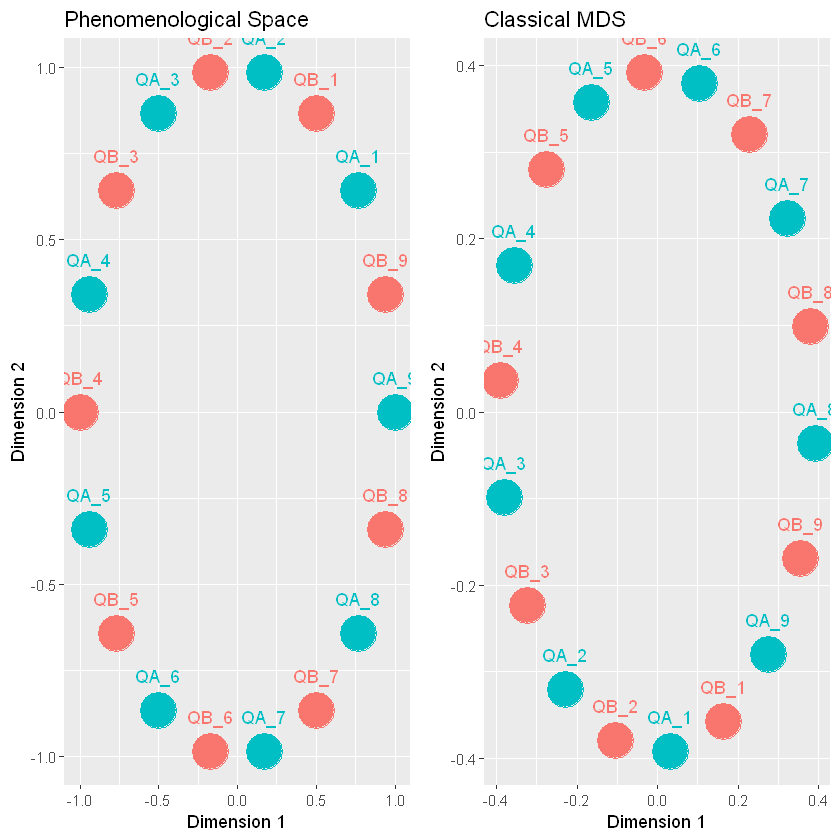

In [522]:
compare <- compare.plots(qspace.plot, interpolate.plot)
grid.arrange(compare)

### Putting everything together in one go

In [527]:
test <- function(n=9,var=0){
    Q1 <- sample.hue.circle(n.samples=n)
    Q2 <- sample.hue.circle(n.samples=n, offset=0.5)
    qspace.plot <- sample.plot(Q1,Q2)
    interpolate.plot <- cmdsplot(Q1,Q2,n.qualia=n,k=2,var=var)
    compare <- compare.plots(qspace.plot, interpolate.plot)
    grid.arrange(compare)
}


In [556]:
#test(8,var=0.5)

In [575]:
# make a demonstration plot
demo.plot <- function(){
    
    stim.list <- c(8,12,16)
    noise.list <- c(0.01,0.1,0.25,0.5)

    
    k = 0 # counter
    plot_list <- list() # list to store the plots in as we're making them
    
    for(stim in stim.list){
        Q1 <- sample.hue.circle(n.samples=stim)
        Q2 <- sample.hue.circle(n.samples=stim, offset=0.5)
        qspace.plot <- sample.plot(Q1,Q2)
        k = k+1
        plot_list[[k]] <- as.grob(qspace.plot)
        for(noise in noise.list){
            interpolate.plot <- cmdsplot(Q1,Q2,n.qualia=stim,k=2,var=noise)
            k = k+1
            plot_list[[k]] <- interpolate.plot
        }        
    }
    g <- arrangeGrob(grobs = plot_list, ncol = length(noise.list)+1, nrow = length(stim.list))
    ggsave('Demo.png',g,height=15,width=20)
}

In [576]:
demo.plot()

### Testing crap, delete later

In [127]:
d.shepard(c(1,1),c(1,1))

[1] 0

In [89]:
testmat <- matrix(c(1,4,1,4), 2, 2)
apple <- testmat[1,1:2]
grape <- testmat[2,1:2]
print(apple)
d.euclidean(apple,grape)
d.shepard(apple,grape)

[1] 1 1


[1] 4.242641

[1] 18.9305

In [76]:
testmat <- matrix(,nrow=4,ncol=4)
testmat

NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA


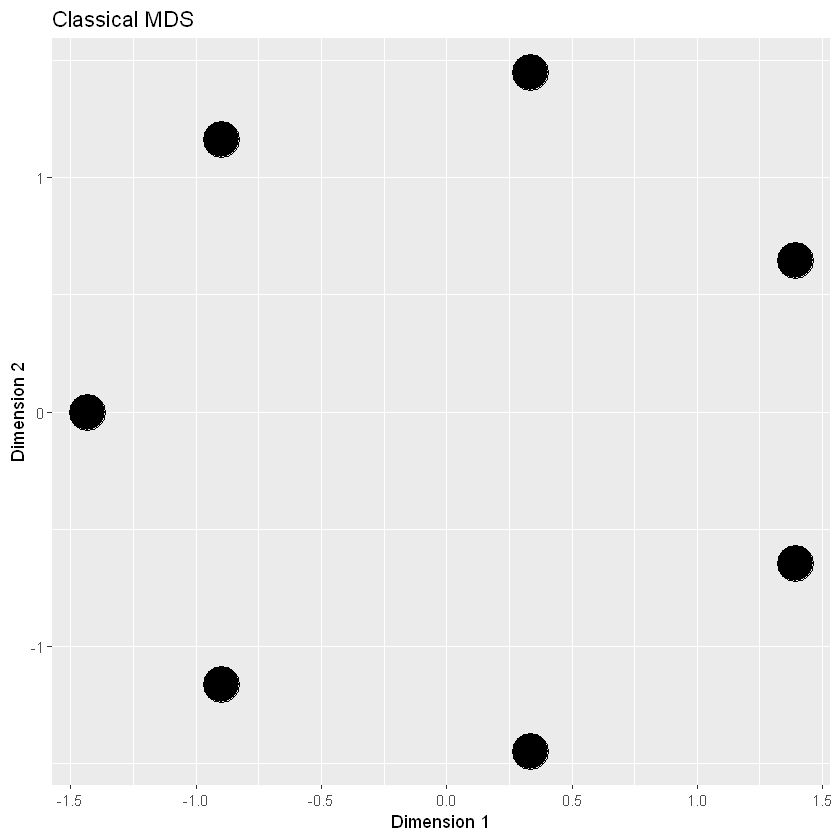

In [146]:
n.samples = 8
testmat <- dr(n.samples=8,Q2,Q1,metric=d.shepard)[1:n.samples,(n.samples+1):(n.samples*2)]
fit <- cmdscale(testmat,k=2)
cmdsplot(fit)

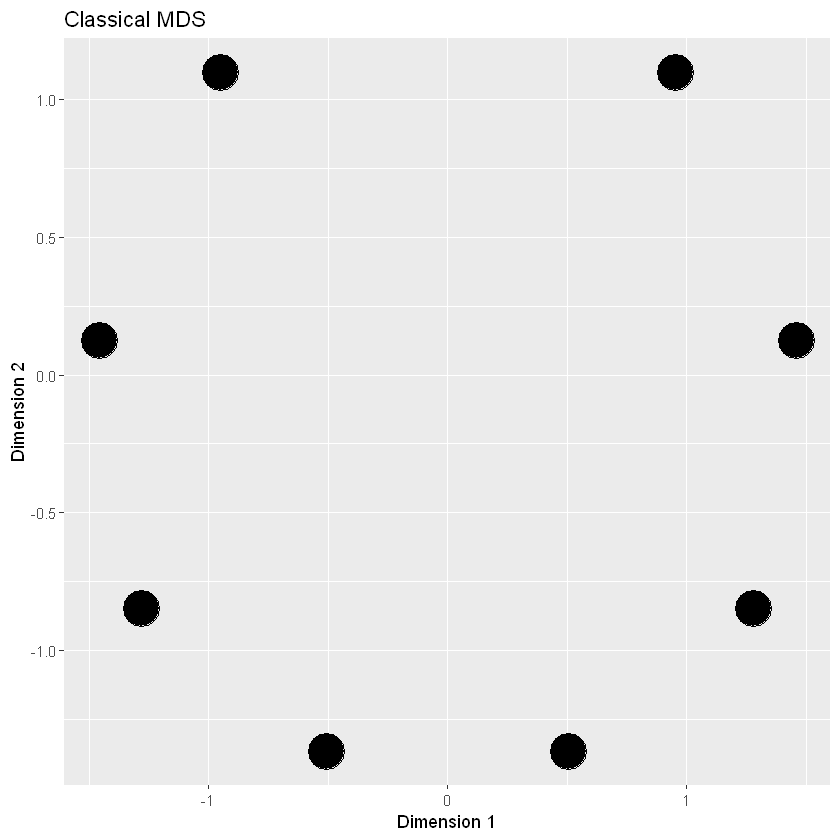

In [145]:
n.samples = 8
testmat <- dr(n.samples=8,Q1,Q2,metric=d.shepard)[1:n.samples,(n.samples+1):(n.samples*2)]
fit <- cmdscale(testmat,k=2)
cmdsplot(fit)